# InfoGAN Implementation

The following is an implementation of [InfoGAN: Interpretable Representation Learning by Information Maximizing Generative Adversarial Nets](https://arxiv.org/abs/1606.03657) (Xi Chen, Yan Duan, Rein Houthooft, John Schulman, Ilya Sutskever, Pieter Abbeel (2016)). 

The code for the main GAN network (before InfoGAN adaptation) is based off of an implementation by [generative-adversarial-networks](https://github.com/jonbruner/generative-adversarial-networks) by Jon Bruner and Adit Deshpande.


##### Implementation by Matt Shaffer (*matt@discovermatt.com*)


In [1]:
import os
import tensorflow as tf
import numpy as np
import datetime
import matplotlib.pyplot as plt
import platform as _platform
%matplotlib inline

if _platform.system() == 'Windows':
    print("Windows OS detected")
    PLATFORM = "win"
    MODEL_DIR = "C:/Development/models/infogan-1"
elif _platform.system() == 'Linux':
    print("Linux OS detected")
    PLATFORM = "linux"
    MODEL_DIR = "/Volumes/Datadrive/Models/infogan-1"
elif _platform.system() == 'Darwin':
    print("Darwin OS detected")
    PLATFORM = "darwin"
    MODEL_DIR = "/Volumes/Datadrive/Models/infogan-1"
else:
    PLATFORM = None
    print("Platform undetected. Set root directories manually.")
    
if not os.path.isdir(MODEL_DIR): # Create model directory if it does not exist
    print("creating directory for saved models")
    os.mkdir(MODEL_DIR)
if not os.path.isdir(MODEL_DIR + "/images"): # Create images directory
    print("creating directory for saved images")
    os.mkdir(MODEL_DIR + "/images")

from tensorflow.examples.tutorials.mnist import input_data
mnist = input_data.read_data_sets("MNIST_data/")

LAST_CKPT = 5000 # Number of last checkpoint to restore and resume training from

Darwin OS detected
Extracting MNIST_data/train-images-idx3-ubyte.gz
Extracting MNIST_data/train-labels-idx1-ubyte.gz
Extracting MNIST_data/t10k-images-idx3-ubyte.gz
Extracting MNIST_data/t10k-labels-idx1-ubyte.gz


## Hyperparams

In [2]:
nb_epochs = 100000 # training epochs | default = 100000
batch_size = 64 # batch size | default = 50
alpha=0.1 # Leaky RELU alpha | range(0.0,1.0) | default = 0.1
lambd=1.0 # lambda for entropy term L(G,Q) | range(0.0,1.0) | default = 1.0
z_dim = 100 # Latent space z, for generator | default = 100
c_dim = 10 # Latent space c. For MNIST: c=10 (Categorical input with 10 classes)
d_alpha = 0.0003 # discriminator learning rate | default = 0.0003
g_alpha = 0.0001 # generator learning rate | default = 0.0001
q_alpha = 0.0001 # q learning rate | default = 0.0001

## Utility Functions

In [3]:
# Optional utility function for Xavier initialization
def xavier_init(dim):
    d = dim[0]
    x_stddev = 1.0 / tf.sqrt(d / 2.0)
    return tf.random_normal(shape=dim, stddev=x_stddev)

## Sample Images

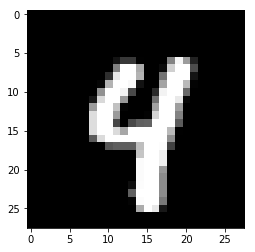

In [5]:
sample = mnist.train.next_batch(1)[0]
sample = sample.reshape([28, 28])
plt.imshow(sample, cmap='gist_gray')

## Discriminator

In [6]:
def discriminator(images, c_dim, batch_size, reuse_variables=None):
    with tf.variable_scope(tf.get_variable_scope(), reuse=reuse_variables) as scope: 
        # First convolutional and pool layers
        # This finds 32 different 5 x 5 pixel features
        d_w1 = tf.get_variable('d_w1', [5, 5, 1, 32], initializer=tf.truncated_normal_initializer(stddev=0.02))
        d_b1 = tf.get_variable('d_b1', [32], initializer=tf.constant_initializer(0))
        d1 = tf.nn.conv2d(input=images, filter=d_w1, strides=[1, 1, 1, 1], padding='SAME')
        d1 = d1 + d_b1
        d1 = tf.maximum(d1, alpha*d1) # Leaky Relu
        d1 = tf.nn.avg_pool(d1, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='SAME')

        # Second convolutional and pool layers
        # This finds 64 different 5 x 5 pixel features
        d_w2 = tf.get_variable('d_w2', [5, 5, 32, 64], initializer=tf.truncated_normal_initializer(stddev=0.02))
        d_b2 = tf.get_variable('d_b2', [64], initializer=tf.constant_initializer(0))
        d2 = tf.nn.conv2d(input=d1, filter=d_w2, strides=[1, 1, 1, 1], padding='SAME')
        d2 = d2 + d_b2
        d2 = tf.maximum(d2, alpha*d2) # Leaky Relu
        d2 = tf.nn.avg_pool(d2, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='SAME')

        # First fully connected layer
        d_w3 = tf.get_variable('d_w3', [7 * 7 * 64, 1024], initializer=tf.truncated_normal_initializer(stddev=0.02))
        d_b3 = tf.get_variable('d_b3', [1024], initializer=tf.constant_initializer(0))
        d3 = tf.reshape(d2, [-1, 7 * 7 * 64])
        d3 = tf.matmul(d3, d_w3)
        d3 = d3 + d_b3
        d3 = tf.maximum(d3, alpha*d3) # Leaky Relu

        # Second fully connected layer
        d_w4 = tf.get_variable('d_w4', [1024, 1], initializer=tf.truncated_normal_initializer(stddev=0.02))
        d_b4 = tf.get_variable('d_b4', [1], initializer=tf.constant_initializer(0))
        d4 = tf.matmul(d3, d_w4) + d_b4
        
        # Calculate Q(c|x) using fully connected layer
        q_w1 = tf.get_variable('q_w1', [1, 1024], initializer=tf.truncated_normal_initializer(stddev=0.02))
        q_b1 = tf.get_variable('q_b1', [1024], initializer=tf.constant_initializer(0))
        q1 = tf.matmul(d4, q_w1) + q_b1
        q1 = tf.maximum(q1, alpha*q1) # Leaky Relu
                
        # Linear output layer for Q
        # No activation, and no softmax here. We will calculate entropy in optimization step (same as discriminator)
        q_w2 = tf.get_variable('q_w2', [1024, c_dim], initializer=tf.truncated_normal_initializer(stddev=0.02))
        q_b2 = tf.get_variable('q_b2', [c_dim], initializer=tf.constant_initializer(0))
        Qcx = tf.matmul(q1, q_w2) + q_b2
        
        # d4 and Qcx contain unscaled values
        return d4, Qcx

## Generator

In [7]:
def generator(c, z, batch_size, c_dim, z_dim, reuse_variables=None):
    with tf.variable_scope(tf.get_variable_scope(), reuse=reuse_variables) as scope:
        c = tf.reshape(c, [batch_size, -1]) # reshape: [batch_size, <flattened>] input: [batch_size, c_dim]
        z_latent = tf.concat([z,c], axis=1) # include latent layer c with z tensor as input to generator
        
        g_w1 = tf.get_variable('g_w1', [z_dim + c_dim, 3136], dtype=tf.float32, initializer=tf.truncated_normal_initializer(stddev=0.02))
        g_b1 = tf.get_variable('g_b1', [3136], initializer=tf.truncated_normal_initializer(stddev=0.02))
        g1 = tf.matmul(z_latent, g_w1) + g_b1
        g1 = tf.reshape(g1, [-1, 56, 56, 1])
        g1 = tf.contrib.layers.batch_norm(g1, epsilon=1e-5, scope='bn1')
        g1 = tf.nn.relu(g1)

        # Generate 50 features
        g_w2 = tf.get_variable('g_w2', [3, 3, 1, z_dim/2], dtype=tf.float32, initializer=tf.truncated_normal_initializer(stddev=0.02))
        g_b2 = tf.get_variable('g_b2', [z_dim/2], initializer=tf.truncated_normal_initializer(stddev=0.02))
        g2 = tf.nn.conv2d(g1, g_w2, strides=[1, 2, 2, 1], padding='SAME')
        g2 = g2 + g_b2
        g2 = tf.contrib.layers.batch_norm(g2, epsilon=1e-5, scope='bn2')
        g2 = tf.nn.relu(g2)
        g2 = tf.image.resize_images(g2, [56, 56])

        # Generate 25 features
        g_w3 = tf.get_variable('g_w3', [3, 3, z_dim/2, z_dim/4], dtype=tf.float32, initializer=tf.truncated_normal_initializer(stddev=0.02))
        g_b3 = tf.get_variable('g_b3', [z_dim/4], initializer=tf.truncated_normal_initializer(stddev=0.02))
        g3 = tf.nn.conv2d(g2, g_w3, strides=[1, 2, 2, 1], padding='SAME')
        g3 = g3 + g_b3
        g3 = tf.contrib.layers.batch_norm(g3, epsilon=1e-5, scope='bn3')
        g3 = tf.nn.relu(g3)
        g3 = tf.image.resize_images(g3, [56, 56])

        # Final convolution with one output channel
        g_w4 = tf.get_variable('g_w4', [1, 1, z_dim/4, 1], dtype=tf.float32, initializer=tf.truncated_normal_initializer(stddev=0.02))
        g_b4 = tf.get_variable('g_b4', [1], initializer=tf.truncated_normal_initializer(stddev=0.02))
        g4 = tf.nn.conv2d(g3, g_w4, strides=[1, 2, 2, 1], padding='SAME')
        g4 = g4 + g_b4
        g4 = tf.sigmoid(g4)

        # Dimensions of g4: batch_size x 28 x 28 x 1
        return g4

## Sample Noise

In [8]:
tf.reset_default_graph()
sess = tf.InteractiveSession() #start interactive session for Jupyter notebook

z_noise = tf.placeholder(tf.float32, [None, z_dim], name="z_placeholder")
c_sim = tf.placeholder(tf.float32, [None, c_dim], name="c_placeholder")

g_sample = generator(c_sim, z_noise, 1, c_dim, z_dim)

# Noise sampling for generator inputs
z_batch = np.random.normal(0, 1, [1, z_dim]) # Start with Gaussian noise
c_batch = np.random.multinomial(1, c_dim*[1.0/c_dim], size=1) # Simulated categorical softmax


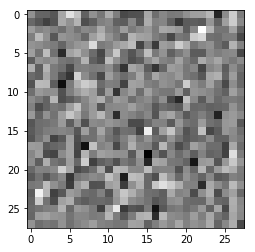

In [9]:
sess.run(tf.global_variables_initializer())
image = sess.run(g_sample, feed_dict={z_noise: z_batch,
                                      c_sim: c_batch})
image = image.reshape([28, 28])
plt.imshow(image, cmap='gist_gray')
sess.close() # End interactive session for Jupyter notebook

In [10]:
tf.reset_default_graph()

# input noise to the generator
z_noise = tf.placeholder(tf.float32, [None, z_dim], name='z_noise') 
# simulated input noise for latent variable c
c_sim = tf.placeholder(tf.float32, [None, c_dim], name="c_sim")
# input images to discriminator
x_in = tf.placeholder(tf.float32, shape = [None,28,28,1], name='x_in') 
# Generator
Gz = generator(c_sim, z_noise, batch_size, c_dim, z_dim) 
# Discriminator Real (prediction probabilities for the real images)
Dx, _ = discriminator(x_in, c_dim, batch_size) 
# Discriminator Fake (prediction probabilities for the generated images) and Q latent predictions
Dg, Qcx = discriminator(Gz, c_dim, batch_size, reuse_variables=True)

#### Discriminator Loss

In [11]:
d_loss_real = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits = Dx, labels = tf.ones_like(Dx)))
d_loss_fake = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits = Dg, labels = tf.zeros_like(Dg)))

#### Generator Loss

In [12]:
g_loss = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits = Dg, labels = tf.ones_like(Dg)))  

#### InfoGAN Loss

In [13]:
# Entropy of Q: lambda*L(G,Q)
q_H = tf.reduce_mean(lambd*tf.nn.sigmoid_cross_entropy_with_logits(logits = tf.nn.softmax(Qcx), 
                                                                   labels = c_sim))
# infoGAN loss function: Loss = V(D,G) - lambda*L(G,Q)
q_loss = tf.abs((g_loss - q_H))

In [14]:
tvars = tf.trainable_variables()

d_vars = [var for var in tvars if 'd_' in var.name]
g_vars = [var for var in tvars if 'g_' in var.name]
q_vars = [var for var in tvars if 'q_' in var.name]

print([v.name for v in d_vars])
print([v.name for v in g_vars])
print([v.name for v in q_vars])

['d_w1:0', 'd_b1:0', 'd_w2:0', 'd_b2:0', 'd_w3:0', 'd_b3:0', 'd_w4:0', 'd_b4:0']
['g_w1:0', 'g_b1:0', 'g_w2:0', 'g_b2:0', 'g_w3:0', 'g_b3:0', 'g_w4:0', 'g_b4:0']
['q_w1:0', 'q_b1:0', 'q_w2:0', 'q_b2:0']


In [15]:
# Train the discriminator
d_train_fake = tf.train.AdamOptimizer(d_alpha).minimize(d_loss_fake, var_list=d_vars)
d_train_real = tf.train.AdamOptimizer(d_alpha).minimize(d_loss_real, var_list=d_vars)

# Train the generator
g_train = tf.train.AdamOptimizer(g_alpha).minimize(g_loss, var_list=g_vars)

# Train the latent variables, update q and g parameters
q_train = tf.train.AdamOptimizer(q_alpha).minimize(q_loss, var_list=q_vars+g_vars)

#### Tensorboard


Run with:
```
tensorboard --logdir=tensorboard/
```
[`http://localhost:6006`](http://localhost:6006) 

In [16]:
# From this point forward, reuse variables
tf.get_variable_scope().reuse_variables()

tf.summary.scalar('Generator_loss', g_loss)
tf.summary.scalar('Discriminator_loss_real', d_loss_real)
tf.summary.scalar('Discriminator_loss_fake', d_loss_fake)
tf.summary.scalar('Q_loss', q_loss)
tf.summary.scalar('Q_entropy', q_H)

images_for_tensorboard = generator(c_sim, z_noise, batch_size, c_dim, z_dim)
tf.summary.image('Generated_images', images_for_tensorboard, 5)
merged = tf.summary.merge_all()
logdir = "tensorboard/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S") + "/"
writer = tf.summary.FileWriter(logdir, sess.graph)

## Model Training

INFO:tensorflow:Restoring parameters from /Volumes/Datadrive/Models/infogan-1/infogan.ckpt-5000
Model restored successfully
Iteration: 0 at 2017-09-11 00:55:42.509531
dLossReal: 0.154056 dLossFake: 0.0478337 G_Loss: 6.48365 Q_loss: 5.74934 Q_entropy: 0.734305


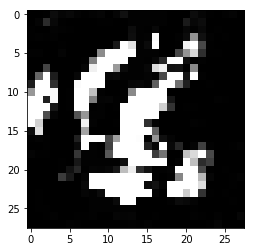

Estimate: [[-20.48678017]]
Iteration: 100 at 2017-09-11 00:57:51.324577
dLossReal: 31.7796 dLossFake: 24.2205 G_Loss: 1.60397e-08 Q_loss: 0.734346 Q_entropy: 0.734346


In [ ]:
sess = tf.Session()
sess.run(tf.global_variables_initializer())
saver = tf.train.Saver()

try:
    MODEL_PATH = MODEL_DIR + '/infogan.ckpt-'
    saver.restore(sess, MODEL_PATH + str(LAST_CKPT))
    print("Model restored successfully")
except Exception as e:
    print("Model restore unsuccessful. Training from Epoch 0")
    
    # Pre-train discriminator
    for i in range(300):
        z_batch = np.random.normal(0, 1, [batch_size, z_dim])
        c_batch = np.random.multinomial(1, 10*[0.1], size=batch_size)
        real_image_batch = mnist.train.next_batch(batch_size)[0].reshape([batch_size, 28, 28, 1])
        _, __, dLossReal, dLossFake, gLoss, qLoss, qH = sess.run([d_train_real, d_train_fake, d_loss_real, d_loss_fake, g_loss, q_loss, q_H],
                                               {x_in: real_image_batch, 
                                                z_noise: z_batch, 
                                                c_sim: c_batch})

        if(i % 100 == 0):
            print("dLossReal:", dLossReal, 
                  "dLossFake:", dLossFake, 
                  "G_Loss:", gLoss, 
                  "Q_loss:", qLoss, 
                  "Q_entropy:", qH)

# Train generator and discriminator together
for i in range(nb_epochs):
    real_image_batch = mnist.train.next_batch(batch_size)[0].reshape([batch_size, 28, 28, 1])
    z_batch = np.random.normal(0, 1, [batch_size, z_dim])
    c_batch = np.random.multinomial(1, 10*[0.1], size=batch_size)
    

    # Train discriminator on both real and fake images
    _, __, dLossReal, dLossFake, gLoss, qLoss, qH = sess.run([d_train_real, d_train_fake, d_loss_real, d_loss_fake, g_loss, q_loss, q_H],
                                           {x_in: real_image_batch, 
                                            z_noise: z_batch, 
                                            c_sim: c_batch})

    # Train generator
    z_batch = np.random.normal(0, 1, [batch_size, z_dim])
    c_batch = np.random.multinomial(1, 10*[0.1], size=batch_size)
    _ = sess.run(g_train, feed_dict={z_noise: z_batch, c_sim: c_batch})

    if i % 10 == 0:
        # Update TensorBoard with summary statistics
        z_batch = np.random.normal(0, 1, [batch_size, z_dim])
        c_batch = np.random.multinomial(1, 10*[0.1], size=batch_size)
        summary = sess.run(merged, {z_noise: z_batch, c_sim: c_batch, x_in: real_image_batch})
        writer.add_summary(summary, i)

    if i % 100 == 0:
        # Every 100 iterations, save a generated image
        print("Iteration:", i, "at", datetime.datetime.now())
        print("dLossReal:", dLossReal, "dLossFake:", dLossFake, "G_Loss:", gLoss, "Q_loss:", qLoss, "Q_entropy:", qH)
        z_batch = np.random.normal(0, 1, [1, z_dim])
        c_batch = np.random.multinomial(1, 10*[0.1], size=1)
        generated_images = generator(c_sim, z_noise, 1, c_dim, z_dim)
        images = sess.run(generated_images, {z_noise: z_batch, c_sim: c_batch})
        plt.imshow(images[0].reshape([28, 28]), cmap='gist_gray')
        plt.savefig(MODEL_DIR + "/images/image-epoch-" + str(i) + ".png")
        
    if i % 1000 == 0:
        # Every 1000 iterations, show a generated image
        plt.show()

        # Show discriminator's estimate
        im = images[0].reshape([1, 28, 28, 1])
        result, _ = discriminator(x_in, c_dim, 1) 
        estimate = sess.run(result, {x_in: im, c_sim: c_batch})
        print("Estimate:", estimate)
    
    if (i % 500 == 0) and (i > 0):
        # Save Checkpoint
        # Use absolute path outside of cloud drive (e.g. Dropbox) to avoid errors
        try:
            save_path = saver.save(sess, MODEL_DIR + '/infogan.ckpt', global_step=i)
            print("Model saved in file: %s" % save_path)
        except Exception as e:
            print("Model save failed: {}".format(e))

## Model Restoring and Results

INFO:tensorflow:Restoring parameters from pretrained-model/pretrained_gan.ckpt


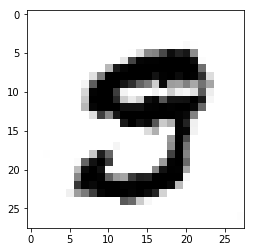

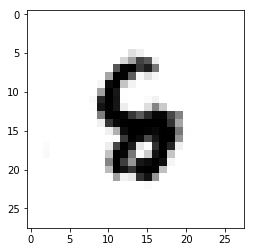

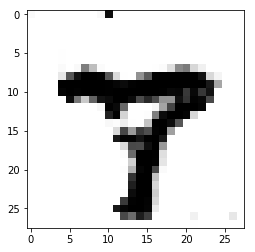

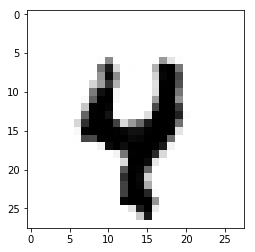

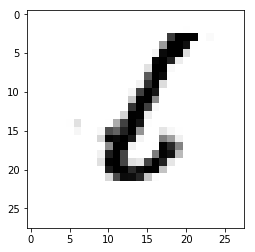

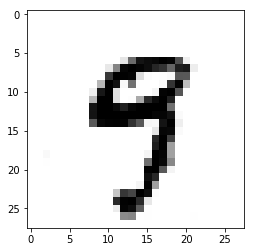

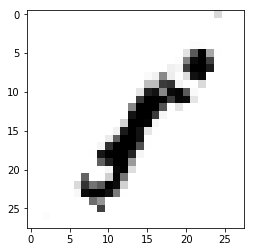

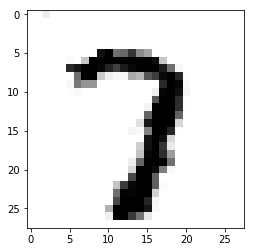

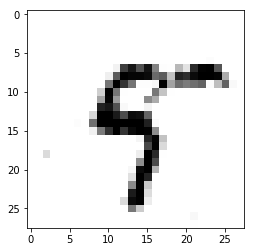

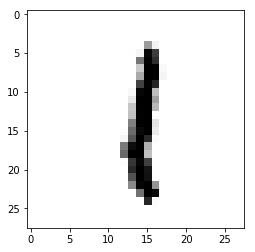

In [15]:
saver = tf.train.Saver()
images_num = 10 # how many images to show
with tf.Session() as sess:
    saver.restore(sess, MODEL_DIR + '/infogan.ckpt-' + LAST_CKPT)
    z_batch = np.random.normal(0, 1, size=[images_num, z_dim])
    c_batch = np.random.multinomial(1, 10*[0.1], size=images_num)
    z_noise = tf.placeholder(tf.float32, [None, z_dim], name='z_placeholder') 
    generated_images = generator(c_sim, z_noise, images_num, c_dim, z_dim)
    images = sess.run(generated_images, {z_noise: z_batch})
    for i in range(10):
        plt.imshow(images[i].reshape([28, 28]), cmap='gist_gray')
        plt.show()